<a href="https://colab.research.google.com/github/MadhuriKonnur/GeekGoddess/blob/master/TechGig_GG_hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** *Credit card approval  prediction**

using AutoEncoders , LR and XGB  predicted  m13 label for  loan delinqueny
*

by Madhuri Konnur

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
# Data  dependencies
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

###

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score

Using TensorFlow backend.


access data from google  drive , for  example  from  drive  go to sharable  links  of  ( .csv files ) .
Take  test  and  train  data  csv files  shareable  links.
paste  it  and  take  out  id's 

train - https://drive.google.com/open?id=1leP7I4VCJw4huILoIIqf_hJkz_Un2izO
test- https://drive.google.com/open?id=11gV9P9VvhI1hBIwbNptJvuCDHi9J2sX0

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Google drive  data access
train_downloaded=drive.CreateFile({'id':'1leP7I4VCJw4huILoIIqf_hJkz_Un2izO'})
train_downloaded.GetContentFile('train.csv')
test_downloaded=drive.CreateFile({'id':'11gV9P9VvhI1hBIwbNptJvuCDHi9J2sX0'})
test_downloaded.GetContentFile('test.csv')


In [0]:
data=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [8]:
data.head()

,Key,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,?,40.83,3.500,u,g,i,bb,0.500,f,f,0,f,s,1160,0,-
1,2,?,32.25,1.500,u,g,c,v,0.250,f,f,0,t,g,372,122,-
2,3,?,28.17,0.585,u,g,aa,v,0.040,f,f,0,f,g,260,1004,-
3,4,?,29.75,0.665,u,g,w,v,0.250,f,f,0,t,g,300,0,-
4,5,?,26.5,2.710,y,p,?,?,0.085,f,f,0,f,s,80,0,-


In [9]:
# check out the size of the data
print("Train data shape:", data.shape)
print("Test data shape:", test.shape)

Train data shape: (590, 17)
Test data shape: (100, 16)


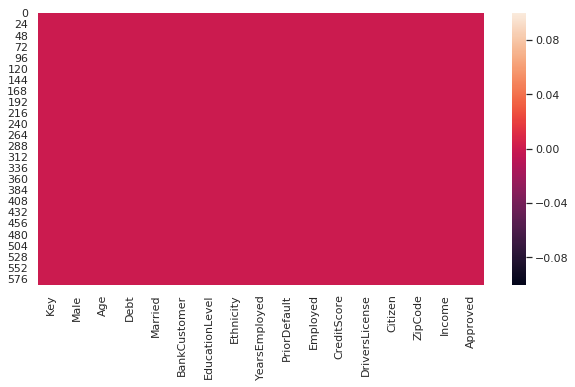

In [10]:
#Checking there is any null value or not
plt.figure(figsize=(10, 5))
sns.heatmap(data.isnull())

In [47]:
data.head()

,Key,Male,Age,Debt,Married,BankCustomer,EducationLevel,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,0,231,3.500,2,1,7,1,0.500,0,0,0,0,2,6,0,1
1,2,0,163,1.500,2,1,2,8,0.250,0,0,0,1,0,95,122,1
2,3,0,124,0.585,2,1,1,8,0.040,0,0,0,0,0,63,1004,1
3,4,0,139,0.665,2,1,13,8,0.250,0,0,0,1,0,75,0,1
4,5,0,107,2.710,3,3,0,0,0.085,0,0,0,0,2,144,0,1


No Missing  data

In [11]:
data.dtypes

Key                 int64
Male               object
Age                object
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
Ethnicity          object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
DriversLicense     object
Citizen            object
ZipCode            object
Income              int64
Approved           object
dtype: object

Encoding string to intiger ( Categoriacal object to intiger)

In [0]:
cols = ('Male', 'Age', 'Married',
       'BankCustomer', 'EducationLevel','Ethnicity','PriorDefault','Employed','DriversLicense','Citizen','ZipCode','Approved')
# removing 'Approved ' for test  data
cols1 = ('Male', 'Age', 'Married',
       'BankCustomer', 'EducationLevel','Ethnicity','PriorDefault','Employed','DriversLicense','Citizen','ZipCode')


In [0]:
from sklearn.preprocessing import LabelEncoder
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data[c].values)) 
    data[c] = lbl.transform(list(data[c].values))

The dataset consists of 16 anonymized variables,'Key', 'Male', 'Age', 'Married',
       'BankCustomer', 'EducationLevel','Ethnicity','PriorDefault','Employed','DriversLicense','Citizen','ZipCode','Approved' etc
and 1 target variable - Approved. 

Total 17 variables
       
       Let's look at the distribution of target.

1    358
0    232
Name: Approved, dtype: int64

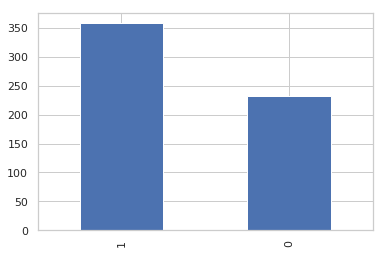

In [19]:
data['Approved'].value_counts().plot('bar')
data['Approved'].value_counts()

In [20]:
vc = data['Approved'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Approved"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Approved" : "Count"})
vc

,Target,Count,percent
0,1,358,60.68
1,0,232,39.32


One of the  challenge of this problem is that the target is slightly imbalanced as 39.32 % cases are approved transactions. But the advantage of the representation learning approach is that it is still able to handle such imbalance nature of the problems. We will look how. For our use-case let's take only about 100 rows of not-approved transactions.

*Consider* only 232 rows of approved cases

In [0]:
app = data[data['Approved'] ==0].sample(232)
not_app = data[data['Approved'] == 1]

df = app.append(not_app).sample(frac=1).reset_index(drop=True)
X = df.drop(['Approved'], axis = 1).values
Y = df["Approved"].values

**Visualize Delinquency and NonDelinquency Transactions**

Let's visualize the nature of Approved(app) and not-app transactions using T-SNE. T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dataset decomposition technique which reduced the dimentions of data and produces only top n components with maximum information.

Every dot in the following represents a transaction. Not approved transactions are represented as Red while Approved transactions are represented as Green. The two axis are the components extracted by tsne.

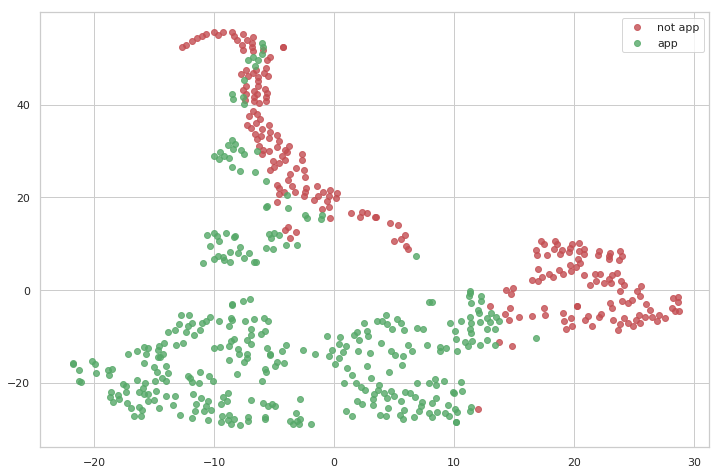

In [170]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='not app')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='app')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")


From the above graph we can observe that there are many "Approved" transactions which are very close to "not_approved" transactions, thus are difficult to accurately classify from a model.

**AutoEncoders to the rescue**

What are Autoencoders? - Autoencoders are a special type of neural network architectures in which the output is same as the input. Autoencoders are trained in an unsupervised manner in order to learn the exteremely low level repersentations of the input data. These low level features are then deformed back to project the actual data. An autoencoder is a regression task where the network is asked to predict its input (in other words, model the identity function). These networks has a tight bottleneck of a few neurons in the middle, forcing them to create effective representations that compress the input into a low-dimensional code that can be used by the decoder to reproduce the original input.




 create an autoencoder model in which we only show the model non-dlq cases. The model will try to learn the best representation of non-dlq cases. The same model will be used to generate the representations of dlq cases and we expect them to be different from non-dlq ones.

Create a network with one input layer and one output layer having identical dimentions ie. the shape of non-dlq cases. We will use keras package.

In [0]:
## input layer 
input_layer = Input(shape=(X.shape[1],))


## encoding part
#encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
#encoded = Dense(50, activation='relu')(encoded)
encoded = Dense(150, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(100, activation='relu')(encoded)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
#decoded = Dense(50, activation='tanh')(encoded)
#decoded = Dense(100, activation='tanh')(decoded)
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)
decoded = Dense(150, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

Create the model architecture by compiling input layer and output layers. Also add the optimizer and loss function, I am using "adadelta" as the optimizer and "mse" as the loss function.

In [0]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

Before training, let's perform min max scaling.

In [0]:
x = data.drop(["Approved"], axis=1)
y = data["Approved"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)

x_norm, x_app = x_scale[y == 0], x_scale[y == 1]



The beauty of this approach is that we do not need too many samples of data for learning the good representations. We will use only 200 rows of not approved cases to train the autoencoder. Additionally, We do not need to run this model for a large number of epochs.

Explanation: The choice of small samples from the original dataset is based on the intuition that one class characteristics (not approved) will differ from that of the other (approved). To distinguish these characteristics we need to show the autoencoders only one class of data. This is because the autoencoder will try to learn only one class and automaticlly distinuish the other class.

In [174]:
autoencoder.fit(x_norm[0:200], x_norm[0:200], 
                batch_size =10, epochs =10, 
                shuffle = True, validation_split = 0.20);

Train on 160 samples, validate on 40 samples
Epoch 1/10
160/160 [==============================] - 1s 7ms/step - loss: 0.2224 - val_loss: 0.1878
Epoch 2/10
160/160 [==============================] - 0s 455us/step - loss: 0.2816 - val_loss: 0.3619
Epoch 3/10
160/160 [==============================] - 0s 339us/step - loss: 0.3732 - val_loss: 0.4004
Epoch 4/10
160/160 [==============================] - 0s 392us/step - loss: 0.3796 - val_loss: 0.4014
Epoch 5/10
160/160 [==============================] - 0s 345us/step - loss: 0.3841 - val_loss: 0.4039
Epoch 6/10
160/160 [==============================] - 0s 358us/step - loss: 0.3711 - val_loss: 0.3794
Epoch 7/10
160/160 [==============================] - 0s 300us/step - loss: 0.3525 - val_loss: 0.3062
Epoch 8/10
160/160 [==============================] - 0s 319us/step - loss: 0.2982 - val_loss: 0.2979
Epoch 9/10
160/160 [==============================] - 0s 303us/step - loss: 0.2845 - val_loss: 0.2802
Epoch 10/10
160/160 [==================

**Obtain the Latent Representations**

Now, the model is trained. We are intereseted in obtaining latent representation of the input learned by the model. This can be accessed by the weights of the trained model. We will create another network containing sequential layers, and we will only add the trained weights till the third layer where latent representation exists.

In [0]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3]) # this one  added extra can be removed

Generate the hidden representations of two classes : not_app and app by predicting the raw inputs using the above model.

In [0]:
norm_hid_rep = hidden_representation.predict(x_norm[:300])
app_hid_rep = hidden_representation.predict(x_app)

**Visualize the latent representations : Approved Vs Not Approved**

Now we will create a training dataset using the latent representations obtained and let's visualize the nature of approved vs not-approved cases.

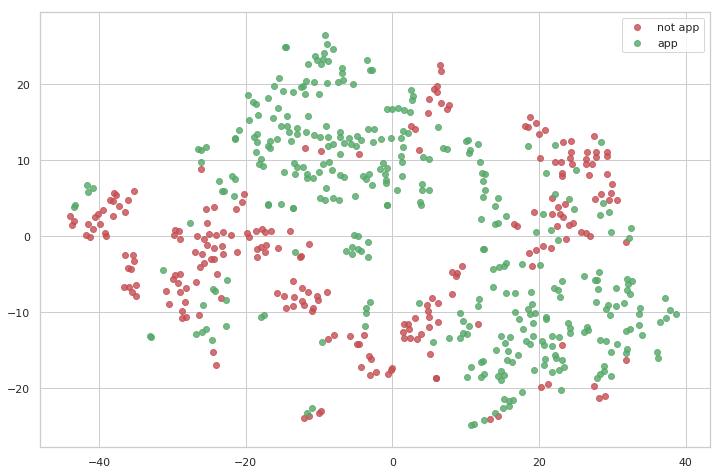

In [177]:
rep_x = np.append(norm_hid_rep, app_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(app_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

What a perfect graph, we can observe that now approved and not-approved transactions are pretty visibile and are linearly separable. Now we dont need any complex model to classify this, even the simpler models can be used to predict. Here is the before and after view of approved and Not approved transactions 

In [178]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original.png'></td><td>
             <img src='latent_representation.png'></td></tr></table>"""))

Actual Representation (Before),Latent Representation (Actual)
,


In [179]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.20,random_state=43)
clf = LogisticRegression(penalty = 'l1',C=0.7, random_state =42).fit(train_x, train_y)
pred_y = clf.predict(val_x)

print (classification_report(val_y, pred_y))
print (accuracy_score(val_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.98      0.89      0.93        46
         1.0       0.93      0.99      0.96        72

    accuracy                           0.95       118
   macro avg       0.96      0.94      0.95       118
weighted avg       0.95      0.95      0.95       118

0.9491525423728814


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [180]:
from sklearn.metrics import roc_auc_score
# calculate AUC
auc = roc_auc_score(val_y, pred_y)
print('AUC: %.3f' % auc)

AUC: 0.939


XGB

In [181]:
import xgboost as xgb
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.20, random_state=43)
clf1 = xgb.XGBClassifier(n_jobs = -1,n_estimators =20,max_depth=10,objective='binary:logistic',scale_pos_weight=5,  gamma=10
                      ).fit(train_x, train_y)
pred_y = clf1.predict(val_x)

print (classification_report(val_y, pred_y))
print (accuracy_score(val_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.97      0.80      0.88        46
         1.0       0.89      0.99      0.93        72

    accuracy                           0.92       118
   macro avg       0.93      0.90      0.91       118
weighted avg       0.92      0.92      0.91       118

0.9152542372881356


In [182]:
# calculate AUC
auc = roc_auc_score(val_y, pred_y)
print('AUC: %.3f' % auc)

AUC: 0.895


Submission

In [0]:
# let's scale  test  value 

# here  also all catagorial vaar to  int
# c is  already defined during train data
from sklearn.preprocessing import LabelEncoder
for c in cols1:
    lbl = LabelEncoder() 
    lbl.fit(list(test[c].values)) 
    test[c] = lbl.transform(list(test[c].values))
    
#Standardising  values  like train data

scaler = preprocessing.MinMaxScaler()
scaler.fit(test.values)
test_x_scale = scaler.transform(test.values)

In [184]:
temp = pd.DataFrame([])
temp['Key']= test['Key']
test_rep_x = hidden_representation.predict(test_x_scale)
temp['Approved'] = [int(x) for x in clf.predict(test_rep_x)]
temp['Approved'].replace([0,1],['+','-'],inplace=True)
temp.to_csv("submission.csv", index = False)
sub= pd.read_csv("submission.csv")
sub.head()


,Key,Approved
0,1,-
1,2,-
2,3,-
3,4,-
4,5,-


In [0]:
# downloading  the submission file directly  (without  google  drive )

from google.colab import files
files.download('submission.csv')

In [185]:
sub.shape

(100, 2)